# Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$ так, чтобы сохранить структуру соседства.

    1. Вероятностная постановка задачи


Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$
так, чтобы сохранить структуру соседства.


        - Вероятности в исходном пространстве

Гауссово ядро для измерения сходства:

$
p_{j|i} = exp(-||x_i - x_j||^2 / (2σ_i^2)) / Σ_{k≠i} exp(-||x_i - x_k||^2 / (2σ_i^2))$

Симметризация вероятностей:

$
p_{ij} = (p_{j|i} + p_{i|j}) / (2n)$

Перплексия (perplexity) как гиперпараметр:

$
Perp(P_i) = 2^{H(P_i)}, $

где $H(P_i) = -Σ_j p_{j|i} log₂ p_{j|i}$

        - Вероятности в целевом пространстве

Распределение Стьюдента с одной степенью свободы:

$
q_{ij} = (1 + ||y_i - y_j||^2)^{-1} / Σ_{k≠l} (1 + ||y_k - y_l||^2)^{-1}$

Преимущества t-распределения:

       * Тяжелые хвосты

       * Устойчивость к проклятию размерности

       * Улучшенное разделение кластеров

       * Функция стоимости (KL-дивергенция)

$C(Y) = KL(P||Q) = Σ_i Σ_j p_{ij} log(p_{ij} / q_{ij})$

    2. Оптимизация функции стоимости

        2.1. Градиент функции стоимости

$∂C/∂y_i = 4 Σ_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

       2.2. Методы оптимизации

Градиентный спуск с моментумом:

$Y^{(t)} = Y^{(t-1)} + η ∂C/∂Y + α(t)(Y^{(t-1)} - Y^{(t-2)})$


Раннее преувеличение (early exaggeration):


$p_{ij} ← p_{ij} × 4 (первые 100 итераций)$


Адаптивное обучение (adaptive learning rate)

        2.3. Сложности оптимизации

            - Невыпуклость функции стоимости

            - Локальные минимумы

            - Чувствительность к начальной инициализации

            - Вычислительная сложность O(n²)

Импорт библиотек

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Задание

1. Провести исследование влияния гиперпараметров на результаты кластеризации с T-SNE
2. Сравнить с PCA
   
Использовать 2 датасета - стандартного типа Ирис или Цифры, и своего. Не забываем про нормировку и eda в целом

=== ИРИС ДАТАСЕТ ===
Размер данных: (150, 4)
Количество классов: 3
Имена признаков: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Имена классов: ['setosa' 'versicolor' 'virginica']

Статистика по признакам:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%           

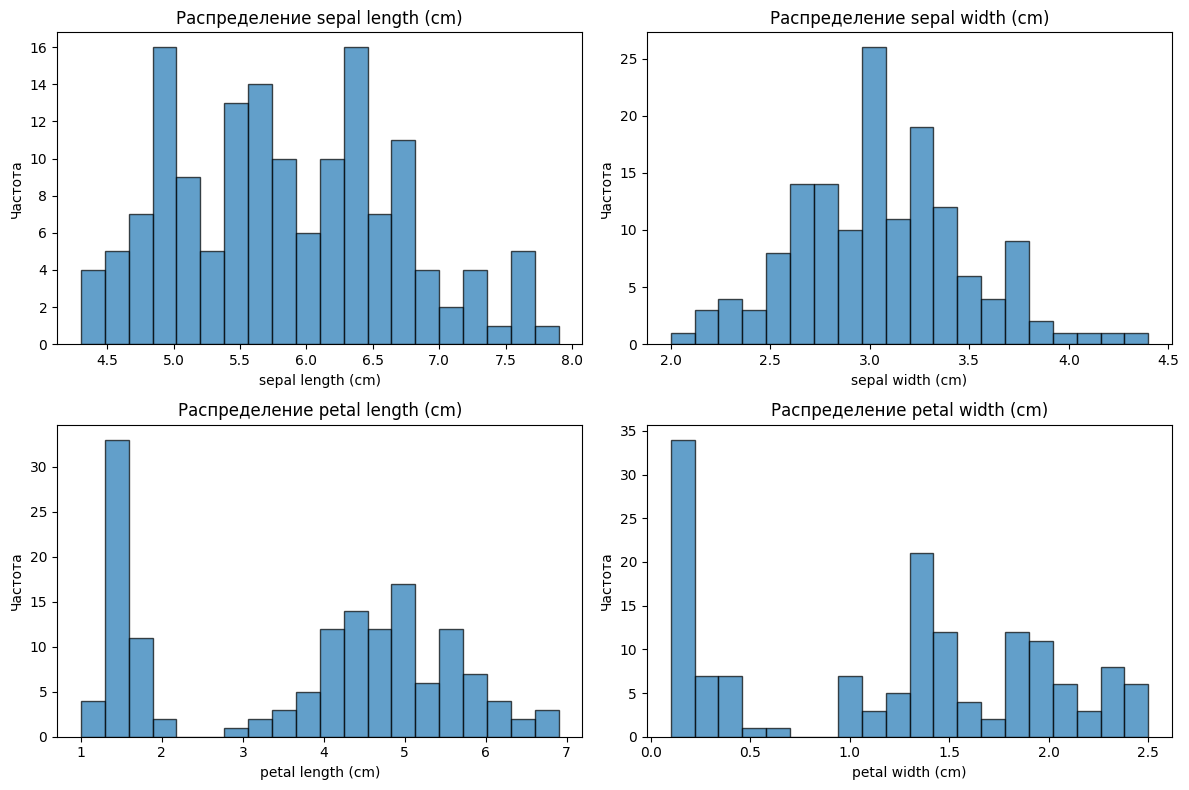

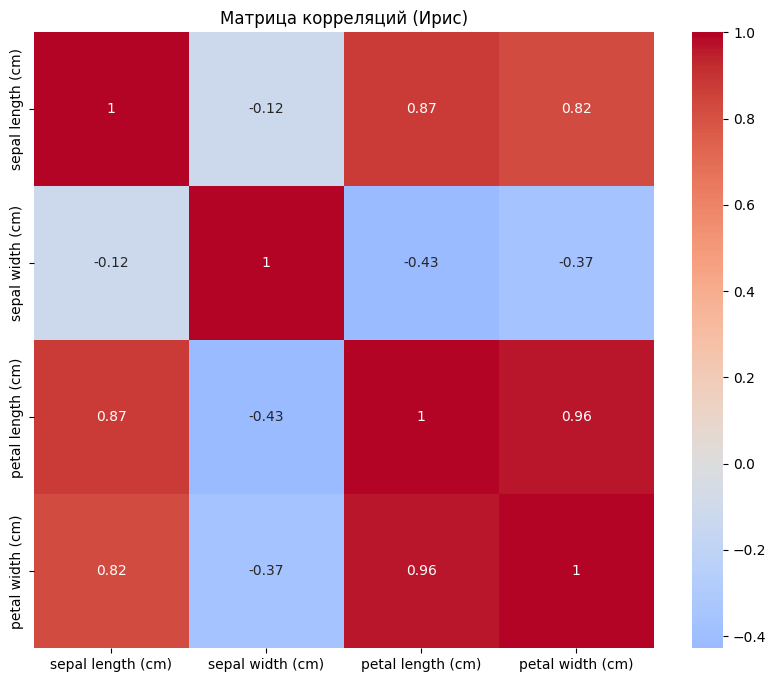

In [36]:
from sklearn import datasets

# Загрузка датасета
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names_iris = iris.feature_names
target_names_iris = iris.target_names

print("=== ИРИС ДАТАСЕТ ===")
print(f"Размер данных: {X_iris.shape}")
print(f"Количество классов: {len(np.unique(y_iris))}")
print(f"Имена признаков: {feature_names_iris}")
print(f"Имена классов: {target_names_iris}")
print(f"\nСтатистика по признакам:")
iris_df = pd.DataFrame(X_iris, columns=feature_names_iris)
print(iris_df.describe())

# Визуализация распределения признаков
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, feature in enumerate(feature_names_iris):
    ax = axes[idx//2, idx%2]
    ax.hist(X_iris[:, idx], bins=20, alpha=0.7, edgecolor='black')
    ax.set_xlabel(feature)
    ax.set_ylabel('Частота')
    ax.set_title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

# Матрица корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(iris_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций (Ирис)')
plt.show()

In [37]:
from sklearn.datasets import load_digits

# 1. Загрузка данных
digits = load_digits()
X = digits.data
y = digits.target

Разделить выборку на фичи и целевую переменную

In [38]:
feature_cols = [f'pixel_{i}_{j}' for i in range(8) for j in range(8)]
X = pd.DataFrame(X, columns=feature_cols)
y = pd.Series(y, name='digit')

print(X.shape, y.shape)

(1797, 64) (1797,)


Нормировка

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)

Доля объяснённой дисперсии: [0.12033916 0.09561054] Суммарно: 0.2159497050083281


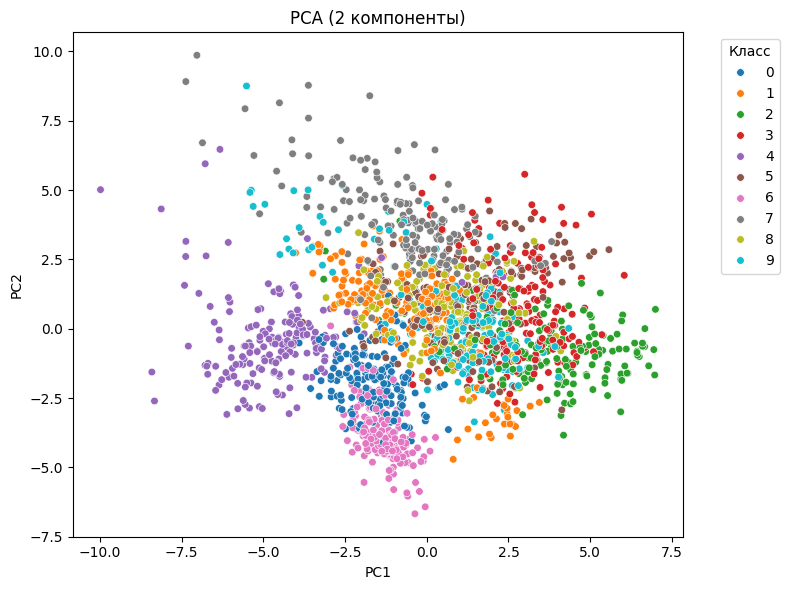

In [40]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Доля объяснённой дисперсии:", pca.explained_variance_ratio_,
      "Суммарно:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

TSNE 2 компоненты

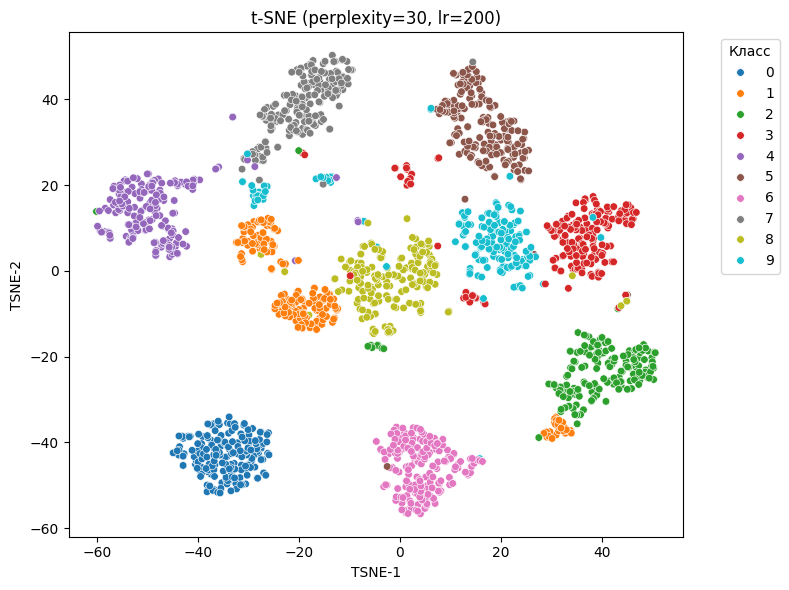

In [41]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="tab10", s=30)
plt.title("t-SNE (perplexity=30, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import pairwise_distances

def separation_score(X_2d, y):
    y_array = np.array(y)
    D = pairwise_distances(X_2d)
    same = D[y_array[:, None] == y_array[None, :]]
    diff = D[y_array[:, None] != y_array[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()

pca_same, pca_diff, pca_ratio = separation_score(X_pca, y)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_tsne, y)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)


PCA:  среднее расстояние внутри класса = 2.46823439916382 , между классами = 4.761456156687811 , ratio = 1.9290939945982768
t-SNE: среднее расстояние внутри класса = 13.999029 , между классами = 55.66477 , ratio = 3.9763305


Вычислить и отрисовать T-SNE с разным значением Perplexity

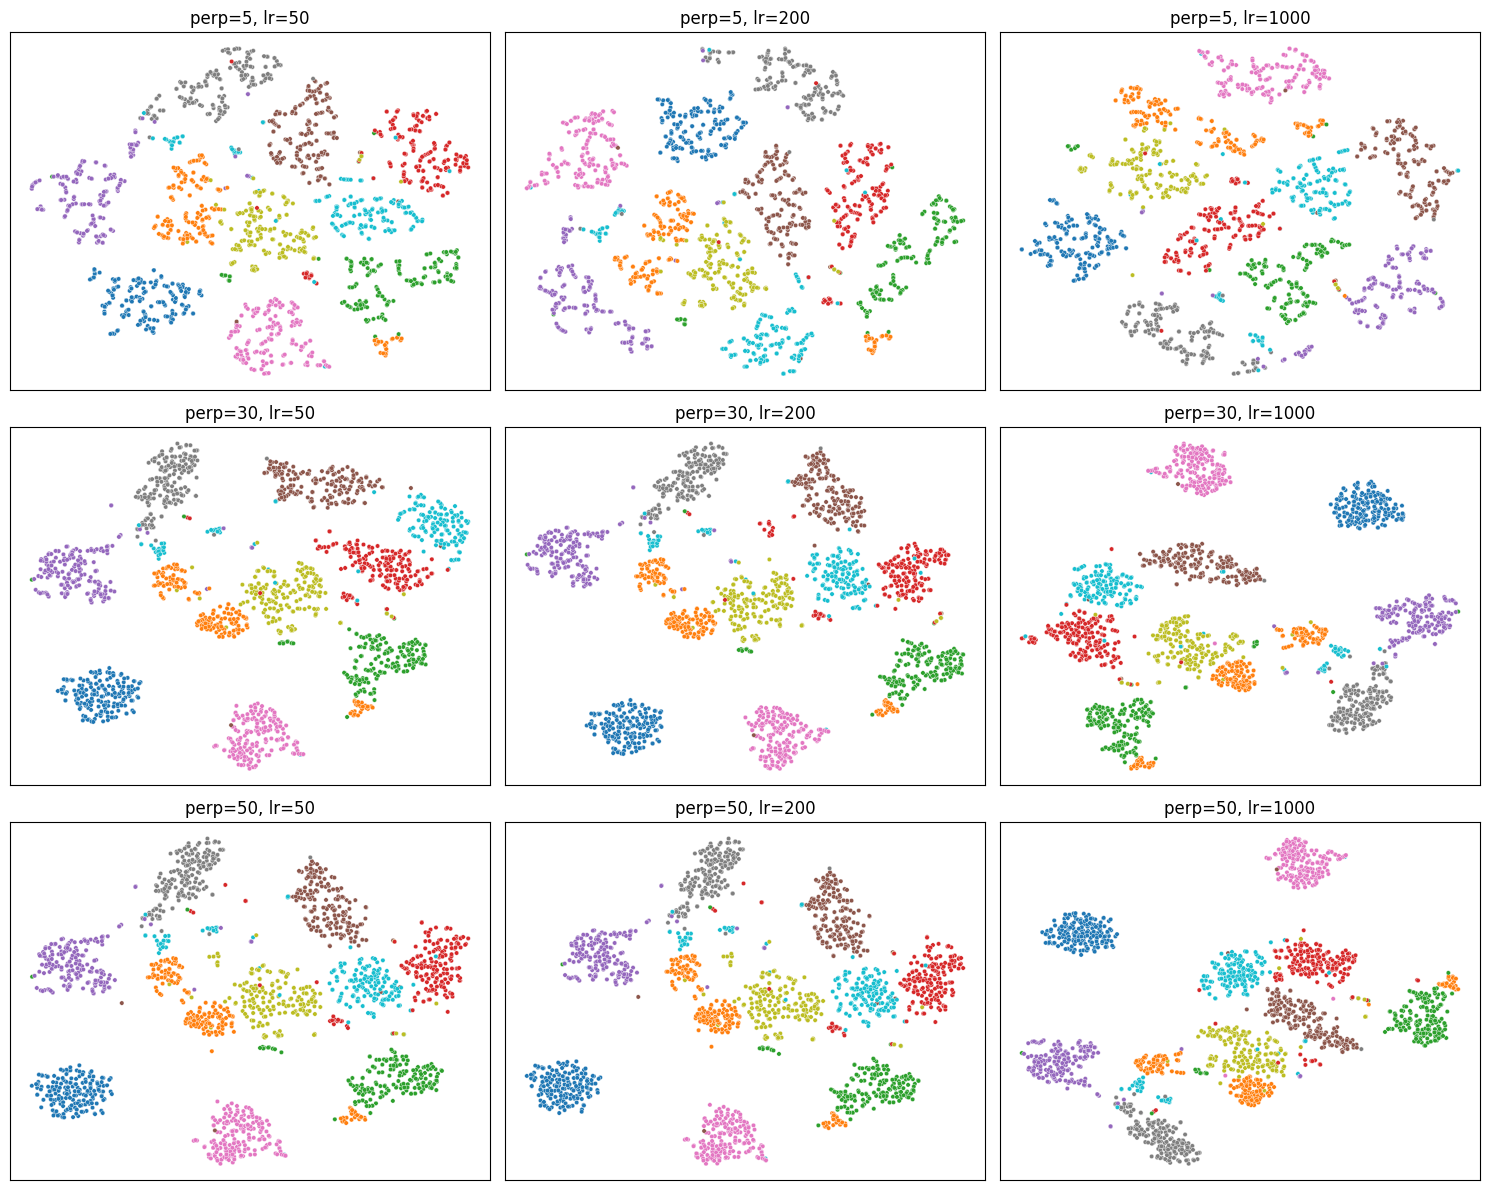

In [44]:
perplexities = [5, 30, 50]
learning_rates = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            n_components=2,
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

Проанализируйте:

как меняется форма кластеров,

возникают ли “разрывы” или слияния при разных параметрах,

насколько стабилен рисунок при небольших изменениях параметров.

PCA: устойчивая структура
Для PCA параметров немного (по сути только число компонент), проекция при фиксированном random_state практически не меняется, что показывает устойчивость метода.

Можно показать, что при разных n_components (2, 3, больше) первые две компоненты остаются близкими, а общая структура мало меняется.

### Ответ:

Форма кластеров:

— при увеличении perplexity кластеры крупнее и меньше по числу

— при увеличении lr кластеры размываются, деформируются

Разрывы/слияния:

— при небольшом perplexity часто разрывы (фрагментация)

— при увеличении lr возможны слияния

Наиболее устойчива комбинация perp = 30–50, lr = 50–200. Наименее стабильна perp = 5, lr = 1000

In [46]:
pca_10 = PCA(n_components=10, random_state=42)
X_pca_10 = pca_10.fit_transform(X_scaled)

print("Суммарная объяснённая дисперсия (10 компонент):",
      pca_10.explained_variance_ratio_.sum())


Суммарная объяснённая дисперсия (10 компонент): 0.5887375533730299


In [47]:
path = "../fruit_classification_dataset.csv"
df = pd.read_csv(path)
df.head()

,size (cm),shape,weight (g),avg_price (₹),color,taste,fruit_name
0,25.4,round,3089.2,137.1,green,sweet,watermelon
1,24.6,round,3283.9,163.8,green,sweet,watermelon
2,7.8,round,319.0,91.3,green,sweet,custard apple
3,20.0,oval,1607.0,85.7,orange,sweet,papaya
4,10.2,long,131.5,37.8,yellow,sweet,banana


In [48]:
# Ограничиваем количество классов
n_classes = 5
top_classes = df['fruit_name'].value_counts().head(n_classes).index
df = df[df['fruit_name'].isin(top_classes)]
print(f"Оставили {n_classes} самых частых классов: {list(top_classes)}")

feature_cols = [c for c in df.columns if c != "target"]
X_own = df[feature_cols]
y_own = df["fruit_name"]
print(X_own.shape, len(np.unique(y_own)))


Оставили 5 самых частых классов: ['pomegranate', 'pear', 'pineapple', 'custard apple', 'papaya']
(2626, 7) 5


In [49]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import numpy as np

# Кодируем y и сохраняем названия классов
label_encoder = LabelEncoder()
y_own = label_encoder.fit_transform(y_own)
class_names = label_encoder.classes_

print(f"\nВсего записей: {len(df)}")
print(f"Количество классов: {len(class_names)}")
print(f"Классы: {class_names}")

# Преобразуем X
numerical_features = ['size (cm)', 'weight (g)', 'avg_price (₹)']
categorical_features = ['shape', 'color', 'taste']

# OneHot кодирование категориальных признаков
ohe = OneHotEncoder(drop='first', sparse_output=False)
X_cat = ohe.fit_transform(df[categorical_features])
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# Числовые признаки оставляем как есть
X_num = df[numerical_features].values

# Объединяем
X_own = np.hstack([X_cat, X_num])
feature_names = list(cat_feature_names) + numerical_features


Всего записей: 2626
Количество классов: 5
Классы: ['custard apple' 'papaya' 'pear' 'pineapple' 'pomegranate']


In [50]:
scaler = StandardScaler()
X_own_scaled = scaler.fit_transform(X_own)


=== ДАТАСЕТ ФРУКТОВ ===
Размер данных: (2626, 8)
Количество классов: 5
Имена классов: ['custard apple' 'papaya' 'pear' 'pineapple' 'pomegranate']
Количество признаков: 8
Имена признаков: ['shape_round', 'color_green', 'color_orange', 'color_red', 'taste_tangy', 'size (cm)', 'weight (g)', 'avg_price (₹)']
         size (cm)   weight (g)  avg_price (₹)
count  2626.000000  2626.000000    2626.000000
mean     11.564851   680.638880      90.046154
std       5.114334   551.724701      17.536979
min       6.300000   162.000000      63.000000
25%       7.500000   235.925000      76.400000
50%       8.400000   298.800000      86.750000
75%      15.700000  1251.450000      97.000000
max      22.000000  1649.300000     131.900000


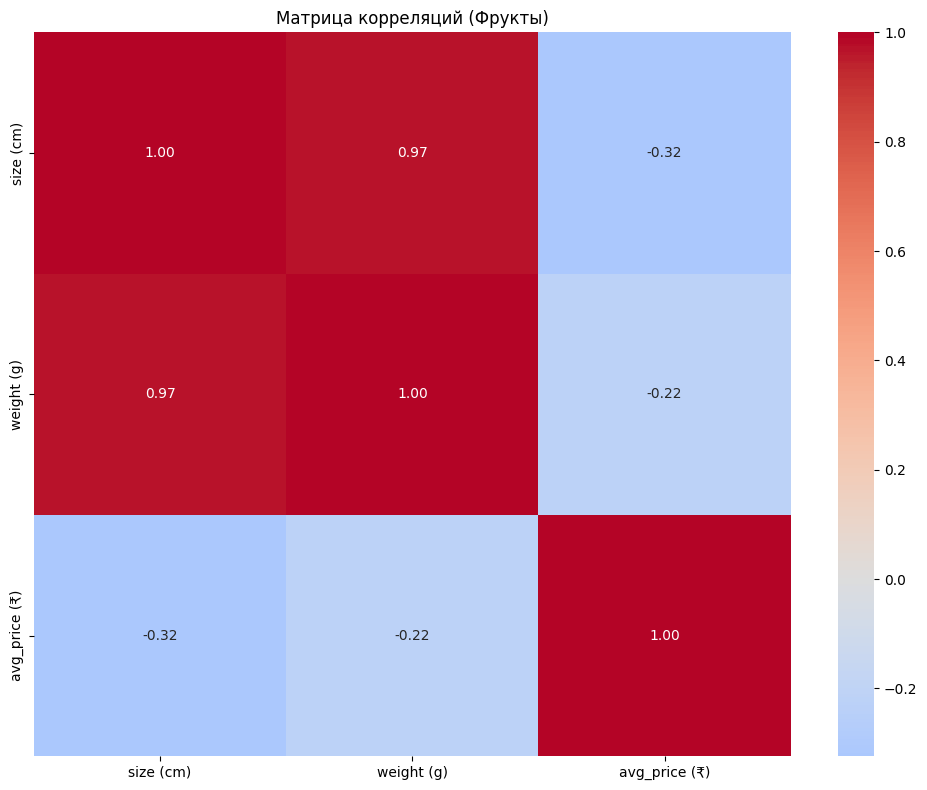

In [51]:
print("\n=== ДАТАСЕТ ФРУКТОВ ===")
print(f"Размер данных: {X_own.shape}")
print(f"Количество классов: {len(class_names)}")
print(f"Имена классов: {class_names}")
print(f"Количество признаков: {len(feature_names)}")
print(f"Имена признаков: {feature_names}")

print(df.describe())

# Матрица корреляций
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций (Фрукты)')
plt.tight_layout()
plt.show()

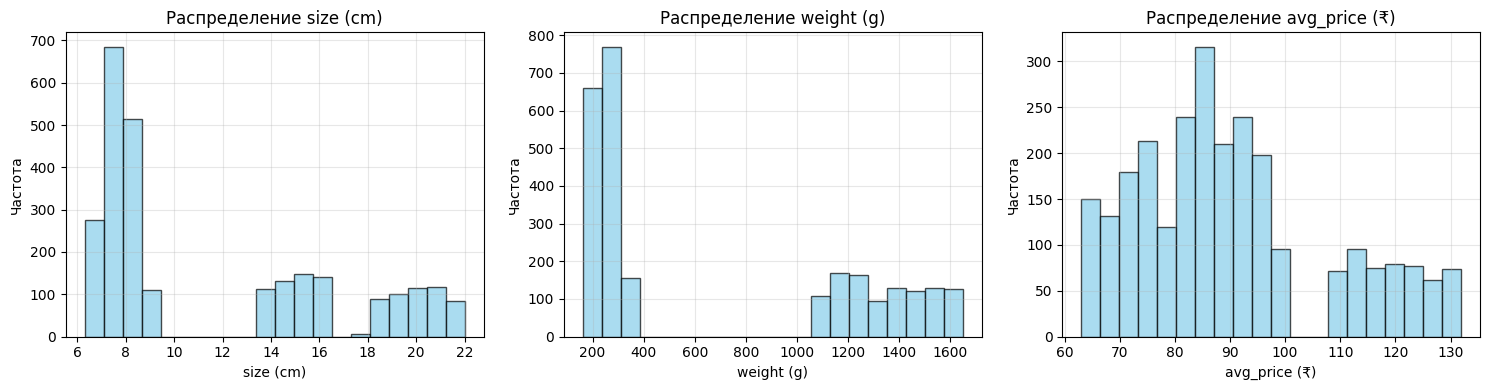

In [52]:
# Визуализация распределения признаков
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    ax.hist(df[feature], bins=20, alpha=0.7, edgecolor='black', color='skyblue')
    ax.set_xlabel(feature)
    ax.set_ylabel('Частота')
    ax.set_title(f'Распределение {feature}')
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Доля объяснённой дисперсии: [0.49904139 0.28353624] Суммарно: 0.7825776343522712


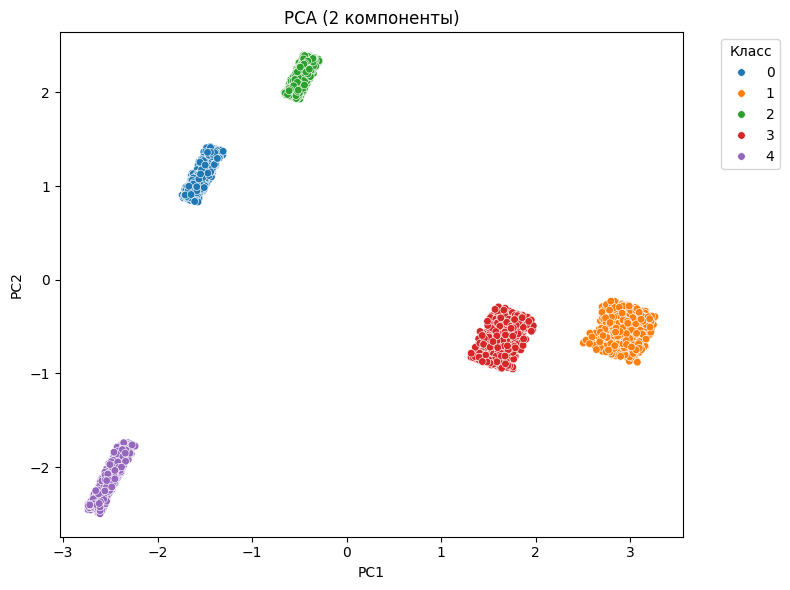

In [53]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_own_scaled)

print("Доля объяснённой дисперсии:", pca.explained_variance_ratio_,
      "Суммарно:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_own, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

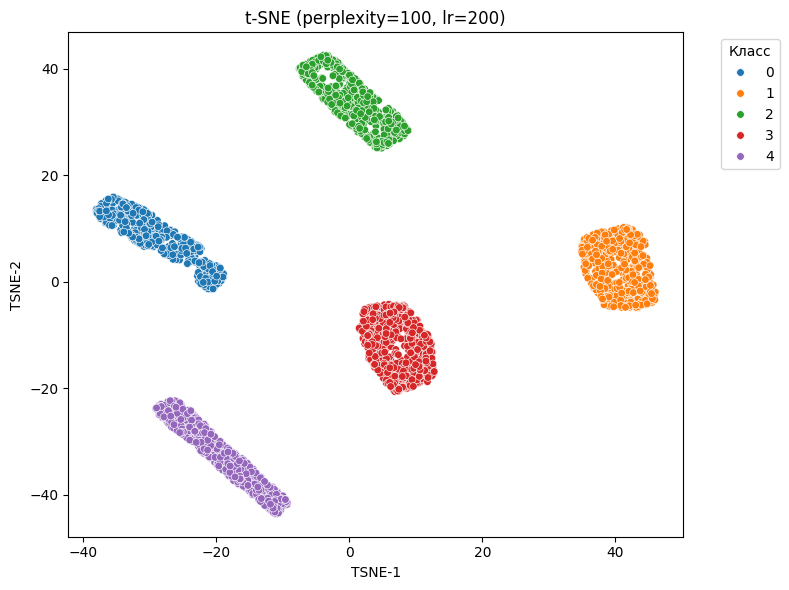

In [56]:
tsne = TSNE(
    n_components=2,
    perplexity=100,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_own_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_own, palette="tab10", s=30)
plt.title("t-SNE (perplexity=100, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import pairwise_distances

def separation_score(X_2d, y):
    y_array = np.array(y)
    D = pairwise_distances(X_2d)
    same = D[y_array[:, None] == y_array[None, :]]
    diff = D[y_array[:, None] != y_array[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()

pca_same, pca_diff, pca_ratio = separation_score(X_pca, y_own)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_tsne, y_own)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)


PCA:  среднее расстояние внутри класса = 0.2416237863535328 , между классами = 3.7207691517679353 , ratio = 15.399018482078901
t-SNE: среднее расстояние внутри класса = 8.124977 , между классами = 50.116444 , ratio = 6.1681952


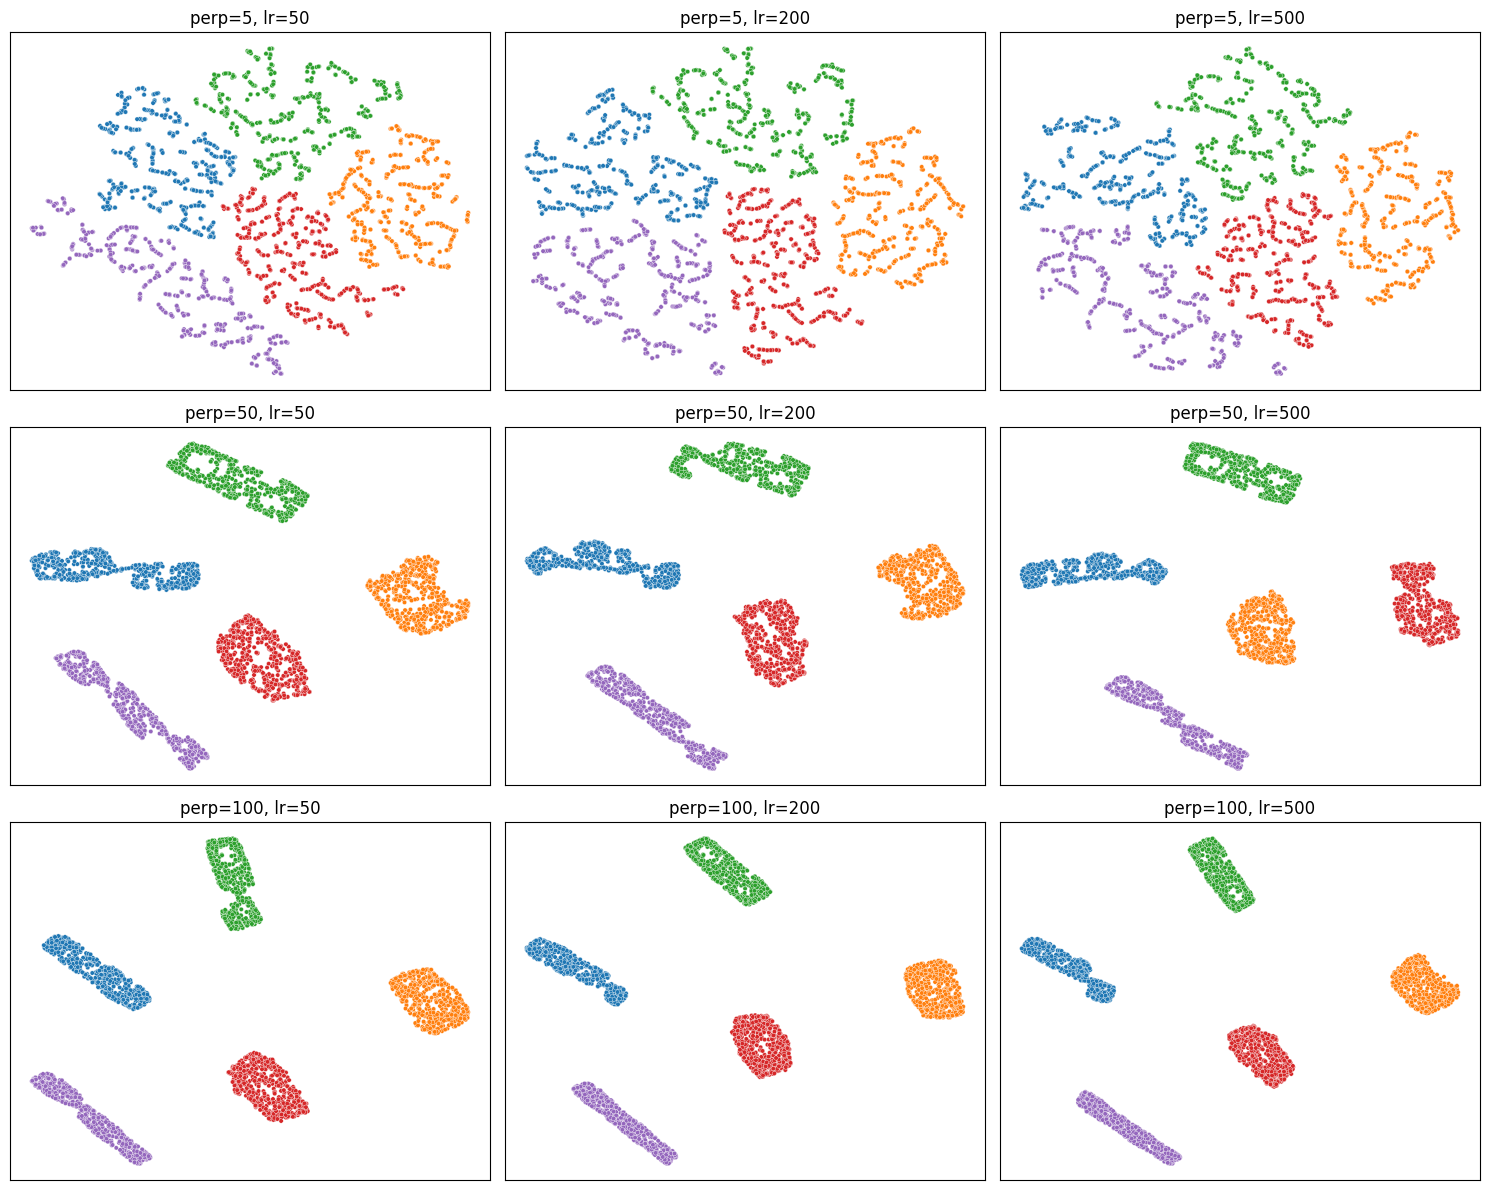

In [58]:
perplexities = [5, 50, 100]
learning_rates = [50, 200, 500]

fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            n_components=2,
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_own_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

In [59]:
# from sklearn.decomposition import PCA

# components_to_try = [2, 3, 4]

# fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# for i, n_comp in enumerate(components_to_try):
#     pca = PCA(n_components=n_comp, random_state=42)
#     X_pca = pca.fit_transform(X_own_scaled)

#     scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], 
#                             c=y_own, cmap='tab10', s=30)
                            
#     axes[i].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
#     axes[i].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
#     axes[i].set_title(f"{n_comp} компоненты\n"
#                      f"Доля объяснённой дисперсии: {pca.explained_variance_ratio_.sum():.1%}")
#     axes[i].grid(alpha=0.3)

# plt.tight_layout()
# plt.show()